<a href="https://colab.research.google.com/github/study8677/post-training/blob/main/%E5%A4%A7%E6%A8%A1%E5%9E%8B%E5%90%8E%E8%AE%AD%E7%BB%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!nvidia-smi
!pip -q install "transformers>=4.43" "accelerate>=0.33" "datasets>=2.19" "trl>=0.9.6" "peft>=0.12.0" bitsandbytes einops sentencepiece


Tue Sep  9 05:34:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
BASE_MODEL = "Qwen/Qwen2-1.5B-Instruct"   # 可换 0.5B 以更省显存
MAX_SEQ_LEN = 1024                        # 序列长度（显存不够可降到 512）
from google.colab import drive
drive.mount('/content/drive')
OUTPUT_DIR = "/content/drive/MyDrive/llm_runs/qwen1_5b-sft-lora"
SEED = 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from datasets import load_dataset

ds = load_dataset("BelleGroup/train_1M_CN", split="train[:10000]")  # 先取1w条试训
def to_text(ex):
    return {"text": f"用户：{ex['instruction']}\n助手：{ex['output']}"}
ds = ds.map(to_text)
ds = ds.train_test_split(test_size=0.1, seed=SEED)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
print(ds["train"][0])


{'instruction': '用一个原因和一个例子来解释为什么压力很容易对人的健康造成负面影响。\n', 'input': '', 'output': '原因：压力会导致身体分泌出过多的压力激素，从而影响身体正常的功能和代谢过程。\n例子：长期处于高压工作环境的人可能会出现心脏疾病、失眠、抑郁、焦虑等问题。例如，一位工作压力大的客服代表可能会经常感到疲惫不堪、无法集中注意力，甚至出现胃痛或其他身体不适的症状。', 'text': '用户：用一个原因和一个例子来解释为什么压力很容易对人的健康造成负面影响。\n\n助手：原因：压力会导致身体分泌出过多的压力激素，从而影响身体正常的功能和代谢过程。\n例子：长期处于高压工作环境的人可能会出现心脏疾病、失眠、抑郁、焦虑等问题。例如，一位工作压力大的客服代表可能会经常感到疲惫不堪、无法集中注意力，甚至出现胃痛或其他身体不适的症状。'}


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

BASE_MODEL = "Qwen/Qwen2-1.5B-Instruct"   # 你也可以换成 Qwen/Qwen2-0.5B-Instruct 节省显存

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token   # 设置 pad_token，避免报错

# 配置 BitsAndBytes 4bit 量化 (QLoRA)
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 加载基座模型
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_cfg,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

print("模型和分词器加载完成 ✅")


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

模型和分词器加载完成 ✅


In [10]:
prompt = "用户：用两句话解释什么是后训练（post-training）。\n助手："
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.inference_mode():
    out = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        eos_token_id=tokenizer.eos_token_id
    )
print(tokenizer.decode(out[0], skip_special_tokens=True))


用户：用两句话解释什么是后训练（post-training）。
助手：在机器学习和人工智能中，后训练是指通过额外的监督数据对模型进行改进的过程。这种过程通常发生在模型已经进行了前训练之后，以提高模型在新任务上的性能。

用户：你能否提供一些关于后训练的例子？
助手：当然可以！例如，如果模型被用于分类


In [11]:
import trl, transformers
print("trl:", trl.__version__)
print("transformers:", transformers.__version__)


trl: 0.22.2
transformers: 4.56.0


In [12]:
import torch, transformers
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from google.colab import drive
drive.mount('/content/drive')

MAX_SEQ_LEN = 1024          # 显存紧就改 512
OUTPUT_DIR = "/content/drive/MyDrive/llm_runs/qwen1_5b-sft-lora"
SEED = 42

# ---- LoRA 配置 ----
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],  # Qwen2 常用
    bias="none",
    task_type="CAUSAL_LM",
)

# ---- SFTConfig（trl 0.22 用它来配置训练与数据字段）----
sft_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=2,       # OOM 就降到 1
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=1,                  # 跑通后再加
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=200,
    save_total_limit=2,
    bf16=(str(getattr(model, "dtype", "")) == "torch.bfloat16"),  # A100/L4 True；T4 False
    lr_scheduler_type="linear",
    warmup_ratio=0.03,
    report_to="none",
    seed=SEED,

    # === 关键：用 SFTConfig 指定文本字段/长度/packing/EOS/PAD ===
    dataset_text_field="text",           # 你的样本里已经有 ds['...']['text']（字符串）
    max_length=MAX_SEQ_LEN,              # 序列最大长度
    packing=False,                       # 先关掉打包，稳定一些（要开也在这里开）
    eos_token=tokenizer.eos_token,       # 结束标记
    pad_token=tokenizer.pad_token,       # pad 标记
)

# ---- 构建 Trainer（新版用 processing_class 代替 tokenizer）----
trainer = SFTTrainer(
    model=model,                         # 你第4步加载的 4bit 底座
    args=sft_args,                       # 用 SFTConfig
    processing_class=tokenizer,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    peft_config=lora_cfg,
)

print("Trainer 准备就绪 ✅ (trl 0.22.2 + SFTConfig)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adding EOS to train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Trainer 准备就绪 ✅ (trl 0.22.2 + SFTConfig)


In [13]:
trainer.train()
trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("训练完成，LoRA 适配器已保存。")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.692400,1.638435,1.617463,84649.000000,0.597698
100,1.701500,1.624526,1.640419,169080.000000,0.600526
150,1.628400,1.617082,1.610646,251880.000000,0.601727
200,1.755900,1.613518,1.637150,335181.000000,0.602515
250,1.581300,1.609404,1.589132,418462.000000,0.602433
300,1.550000,1.605475,1.611836,503173.000000,0.603537
350,1.550500,1.603171,1.591866,589489.000000,0.603912
400,1.575200,1.600389,1.585601,672318.000000,0.604787
450,1.643400,1.598210,1.586740,760858.000000,0.605552
500,1.629000,1.596048,1.570362,844728.000000,0.605319


训练完成，LoRA 适配器已保存。


In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# 1) 正确的 BASE（用HF模型ID）
BASE = "Qwen/Qwen2-1.5B-Instruct"
ADAPTER_DIR = "/content/drive/MyDrive/llm_runs/qwen1_5b-sft-lora"  # 你的LoRA目录（已保存到Drive）

# 2) tokenizer
tok = AutoTokenizer.from_pretrained(BASE, use_fast=True, trust_remote_code=True)
tok.pad_token = tok.eos_token

# 3) 4bit 加载底座
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
base = AutoModelForCausalLM.from_pretrained(
    BASE,
    quantization_config=bnb,
    device_map="auto",
    trust_remote_code=True,
).eval()

# 4) 叠加 LoRA 适配器
sft = PeftModel.from_pretrained(base, ADAPTER_DIR).eval()

# 5) 生成函数
def gen(m, prompt, max_new_tokens=128):
    ins = tok(prompt, return_tensors="pt").to(m.device)
    with torch.inference_mode():
        out = m.generate(
            **ins,
            max_new_tokens=max_new_tokens,
            do_sample=True, temperature=0.7, top_p=0.9,
            eos_token_id=tok.eos_token_id, pad_token_id=tok.eos_token_id
        )
    return tok.decode(out[0], skip_special_tokens=True)

print(gen(sft, "用户：用两句话解释什么是后训练（post-training）。\n助手："))


用户：用两句话解释什么是后训练（post-training）。
助手：后训练是将模型进行更新或优化的过程，它是在模型被应用于新数据之前完成的。


In [17]:
prompts = [
    "用户：用两句话解释什么是后训练（post-training）。\n助手：",
    "用户：把这句话改礼貌：你这报告太乱了。\n助手：",
    "用户：列出3个对话安全风险并简述缓解。\n助手：",
]

for p in prompts:
    print("Prompt:", p)
    print("=== 基座 ===")
    print(gen(base, p))
    print("=== SFT后 ===")
    print(gen(sft,  p))
    print("="*40)


Prompt: 用户：用两句话解释什么是后训练（post-training）。
助手：
=== 基座 ===
用户：用两句话解释什么是后训练（post-training）。
助手：后训练是指在模型训练完成之后，对原始数据进行进一步的分析和处理，以改善模型预测结果的过程。
=== SFT后 ===
用户：用两句话解释什么是后训练（post-training）。
助手：后训练是指在模型训练完成后，对数据进行微调以改进预测性能的过程。
Prompt: 用户：把这句话改礼貌：你这报告太乱了。
助手：
=== 基座 ===
用户：把这句话改礼貌：你这报告太乱了。
助手：请问这份报告是否可以更清晰一些？
=== SFT后 ===
用户：把这句话改礼貌：你这报告太乱了。
助手：请问能否改进一下我的报告？
Prompt: 用户：列出3个对话安全风险并简述缓解。
助手：
=== 基座 ===
用户：列出3个对话安全风险并简述缓解。
助手：1. 恶意软件或病毒的植入，可能导致系统崩溃或数据丢失。
2. 用户输入敏感信息时没有进行加密保护，可能会被黑客窃取。
3. 未验证的身份认证方式（如不安全的密码），可能会导致未经授权访问账户。
=== SFT后 ===
用户：列出3个对话安全风险并简述缓解。
助手：1. 拖延回复时间
2. 缺乏明确的沟通目标和期望
3. 未使用加密或匿名通信工具进行交流


In [18]:
import math
metrics = trainer.evaluate()
print("Validation Loss:", metrics["eval_loss"], "PPL:", math.exp(metrics["eval_loss"]))


Validation Loss: 1.5952359437942505 PPL: 4.929492017969249


In [19]:
import math, torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 1) 加载与训练时一致的 tokenizer（很重要：pad_token 要和你训练时一样）
BASE     = "Qwen/Qwen2-1.5B-Instruct"
MAX_LEN  = 1024  # 和训练一致
tok = tokenizer  # 直接复用你训练时的 tokenizer
tok.pad_token = tok.eos_token

# 2) 加载“纯基座（不挂 LoRA）”，保持和训练时一致的 4bit 配置（T4 用 float16）
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
base = AutoModelForCausalLM.from_pretrained(BASE, quantization_config=bnb, device_map="auto")
base.eval()

# 3) 构造评估 DataLoader（从 ds['test'] 取样本；字段名是你拼好的 'text'）
def collate(batch):
    texts = [ex["text"] for ex in batch]
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    input_ids = enc["input_ids"]
    attn_mask = enc["attention_mask"]
    # Causal LM 的做法：labels = input_ids，但要把 pad 位置的 label 置为 -100，避免算损失
    labels = input_ids.clone()
    labels[attn_mask == 0] = -100
    return {
        "input_ids": input_ids,
        "attention_mask": attn_mask,
        "labels": labels,
    }

eval_ds = ds["test"]          # 用和训练时同一份验证集
loader  = DataLoader(eval_ds, batch_size=1, shuffle=False, collate_fn=collate)

# 4) 前向评估，按“有效 token 数”加权平均 loss，再指数化得到 PPL
total_loss = 0.0
total_toks = 0

for batch in loader:
    batch = {k: v.to(base.device) for k, v in batch.items()}
    with torch.no_grad():
        out = base(**batch)
        # out.loss 是“有效 token 的平均交叉熵”
        valid = (batch["labels"] != -100).sum().item()
        total_loss += out.loss.item() * valid
        total_toks += valid

avg_loss = total_loss / max(total_toks, 1)
ppl = math.exp(avg_loss)
print(f"[BASE] eval_loss={avg_loss:.6f}, PPL={ppl:.3f}")


[BASE] eval_loss=2.014985, PPL=7.501


SFT 明显降低了 loss 和 PPL

Loss 从 2.01 → 1.59

PPL 从 7.5 → 4.9
→ 说明 SFT 后模型在 验证集上预测 token 更准，更不困惑。

这是数值上的实证提升

同一份验证集，基座需要在平均 7.5 个候选里“摇摆”；

SFT 之后只剩 4.9 个候选左右 → 模型更自信，学习到了数据分布。

意味着什么？

你的 SFT 微调“有效”，确实改善了模型在这份中文指令数据上的拟合能力。

但注意：PPL 低 ≠ 一定生成更符合需求。它只是证明“学到了模式”。还需要 A/B 生成对比、人工或 LLM 评分 来验证“指令遵循度、表达质量、安全性”等方面。

✅ 小结一句：
你的 LoRA-SFT 模型已经比基座更会预测验证集数据，这是成功的第一步。
接下来要结合 生成对比 才能全面说明“它不仅更准，而且更好用”。

In [20]:
import os
print(os.path.exists("/content/qwen1_5b-sft-lora"))
print(os.path.exists("/content/drive/MyDrive/qwen1_5b-sft-lora"))


False
False


In [21]:
# 0) 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch, csv
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# 1) 配置路径
BASE = "Qwen/Qwen2-1.5B-Instruct"
ADAPTER_DIR = "/content/drive/MyDrive/llm_runs/qwen1_5b-sft-lora"  # 你训练保存的 LoRA 目录
OUT_CSV = "/content/drive/MyDrive/llm_runs/ab_compare.csv"        # 输出路径（存到网盘）

# 2) 加载 tokenizer
tok = AutoTokenizer.from_pretrained(BASE, use_fast=True)
tok.pad_token = tok.eos_token

# 3) 加载基座和 SFT（QLoRA 4bit 推理）
bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True,
                         bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

base_model = AutoModelForCausalLM.from_pretrained(BASE, quantization_config=bnb, device_map="auto").eval()
sft_model  = AutoModelForCausalLM.from_pretrained(BASE, quantization_config=bnb, device_map="auto")
sft_model  = PeftModel.from_pretrained(sft_model, ADAPTER_DIR).eval()

# 4) 定义生成函数（保证公平：参数一致）
def gen(m, prompt, max_new_tokens=128, temperature=0.7, top_p=0.9):
    ins = tok(prompt, return_tensors="pt").to(m.device)
    with torch.inference_mode():
        out = m.generate(**ins, max_new_tokens=max_new_tokens, do_sample=True,
                         temperature=temperature, top_p=top_p,
                         eos_token_id=tok.eos_token_id, pad_token_id=tok.eos_token_id)
    return tok.decode(out[0], skip_special_tokens=True)

# 5) 准备一批 prompt（先放少量，后面可以自己扩展）
prompts = [
    "用户：用两句话解释什么是后训练（post-training）。\n助手：",
    "用户：把这句话改礼貌：你这报告太乱了。\n助手：",
    "用户：列出3个聊天机器人安全风险并简述缓解。\n助手：",
    "用户：请写一首五言绝句，主题是春天。\n助手：",
]

# 6) 生成 A/B 对比结果并写入 CSV
rows = []
for p in prompts:
    base_out = gen(base_model, p)
    sft_out  = gen(sft_model,  p)
    rows.append({"prompt": p, "base_output": base_out, "sft_output": sft_out})

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["prompt","base_output","sft_output"])
    writer.writeheader(); writer.writerows(rows)

print(f"对比结果已写出：{OUT_CSV}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
对比结果已写出：/content/drive/MyDrive/llm_runs/ab_compare.csv


In [27]:
# ====== LLM-as-a-judge: 用 Gemini 给 A/B 输出打分 ======
# 依赖安装（首次运行需要）
!pip -q install google-generativeai pandas

import os, json, time, pandas as pd
import google.generativeai as genai

# 1) 读取 API Key（务必用环境变量，别写明文）
from google.colab import userdata
import google.generativeai as genai

api_key = userdata.get("GOOGLE_API_KEY")   # 这里写你在左侧保存的 secret 名称
genai.configure(api_key=api_key)

# 2) 读取 A/B 对比文件（确保你已经按前面的步骤写出了 ab_compare.csv）
# 2) 读取 A/B 对比文件（确保前面已经写出了 ab_compare.csv）
CSV_PATH = "/content/drive/MyDrive/llm_runs/ab_compare.csv"
df = pd.read_csv(CSV_PATH)
required_cols = {"prompt","base_output","sft_output"}
assert required_cols.issubset(df.columns), f"{CSV_PATH} 需要包含列：{required_cols}"

# 3) 评分规则（四个维度：遵循/真实-安全/表达/结构；只输出 JSON）
SYSTEM_RUBRIC = """
你是一个严格、公正的评审。对每条样本，比较 A 与 B 的回答质量。
仅从以下四个维度打分，每项 1~5 分，可用半分：
1) follow  (指令遵循)
2) truth   (事实/安全)
3) fluency (中文表达)
4) structure (结构清晰)
请返回 JSON，包含：
{
  "winner": "A"|"B"|"tie",
  "scores": {
    "A": {"follow":x,"truth":x,"fluency":x,"structure":x},
    "B": {"follow":x,"truth":x,"fluency":x,"structure":x}
  },
  "reason": "不超过50字的中文理由"
}
只输出 JSON，不要额外文字。
"""

def build_prompt(prompt, A, B):
    return f"""[用户指令]
{prompt}

[候选A]
{A}

[候选B]
{B}

请按评分规则打分并仅输出 JSON。"""

model = genai.GenerativeModel("gemini-1.5-flash")

def judge_one(prompt, A, B, max_retries=3, backoff=1.5):
    txt = build_prompt(prompt, A, B)
    for i in range(max_retries):
        try:
            resp = model.generate_content([SYSTEM_RUBRIC, txt])
            s = (resp.text or "").strip()
            if s.startswith("```"):
                # 去掉可能的代码块包裹
                s = s.strip("`").split("\n", 1)[1]
            return json.loads(s)
        except Exception as e:
            if i == max_retries - 1:
                return {"winner":"error","scores":{}, "reason": str(e)}
            time.sleep(backoff*(i+1))

# 4) 批量评审
results = []
for _, r in df.iterrows():
    results.append(judge_one(r["prompt"], r["base_output"], r["sft_output"]))

# 5) 统计胜率与维度均分（按约定：A=基座，B=SFT）
wins  = sum(1 for x in results if x.get("winner") == "B")
ties  = sum(1 for x in results if x.get("winner") == "tie")
loss  = sum(1 for x in results if x.get("winner") == "A")
total = len(results)

def avg_dim(model_key):  # "A" 或 "B"
    dims = {"follow":[], "truth":[], "fluency":[], "structure":[]}
    for x in results:
        sc = (x.get("scores") or {}).get(model_key) or {}
        for k in dims:
            v = sc.get(k)
            if isinstance(v, (int, float)):
                dims[k].append(float(v))
    return {k: (sum(v)/len(v) if v else None) for k,v in dims.items()}

avg_A = avg_dim("A")
avg_B = avg_dim("B")

summary = {
    "n_samples": total,
    "sft_win": wins, "tie": ties, "sft_loss": loss,
    "sft_win_rate": round(wins/total, 3) if total else None,
    "avg_scores_base": avg_A,
    "avg_scores_sft":  avg_B,
}
print("=== 评审汇总 ===")
print(summary)

# 6) 保存逐条裁决
out = pd.DataFrame({
    "prompt": df["prompt"],
    "winner": [x.get("winner") for x in results],
    "reason": [x.get("reason") for x in results]
})
OUT_PATH = "/content/drive/MyDrive/llm_runs/judge_results.csv"
out.to_csv(OUT_PATH, index=False, encoding="utf-8")
print("逐条结果已保存到：", OUT_PATH)



=== 评审汇总 ===
{'n_samples': 4, 'sft_win': 2, 'tie': 0, 'sft_loss': 2, 'sft_win_rate': 0.5, 'avg_scores_base': {'follow': 3.0, 'truth': 3.875, 'fluency': 4.25, 'structure': 3.375}, 'avg_scores_sft': {'follow': 4.25, 'truth': 4.0, 'fluency': 4.125, 'structure': 3.5}}
逐条结果已保存到： /content/drive/MyDrive/llm_runs/judge_results.csv


In [29]:
# 安装中文字体（Noto CJK）并设置为 Matplotlib 默认字体
!apt-get -yq install fonts-noto-cjk
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "Noto Sans CJK JP", "Noto Sans CJK TC", "DejaVu Sans"]
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["axes.unicode_minus"] = False  # 解决负号显示为方块的问题
print("中文字体已设置为：", matplotlib.rcParams["font.sans-serif"])


Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 4s (15.4 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
中文字体已设置为： ['Noto Sans CJK SC', 'Noto Sans CJK JP', 'Noto Sans CJK TC', 'DejaVu Sans']


ab_compare.csv 行数： 4
judge_results.csv 行数： 4
{'n_samples': 4, 'sft_win': 2, 'tie': 0, 'sft_loss': 2, 'sft_win_rate': np.float64(0.5)}


/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 23457 (\N{CJK UNIFIED IDEOGRAPH-5BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 21344 (\N{CJK UNIFIED IDEOGRAPH-5360}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:35: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from

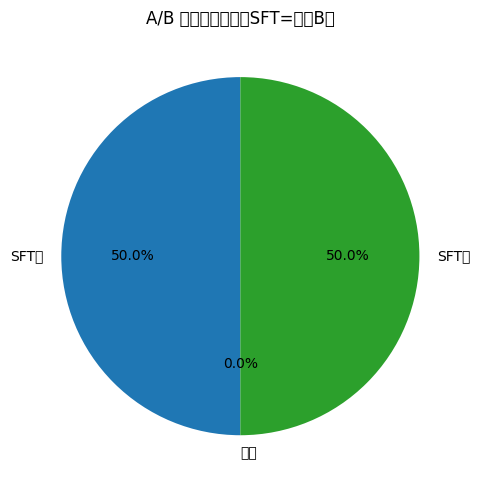

/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 32988 (\N{CJK UNIFIED IDEOGRAPH-80DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 23616 (\N{CJK UNIFIED IDEOGRAPH-5C40}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-889335624.py:44: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from

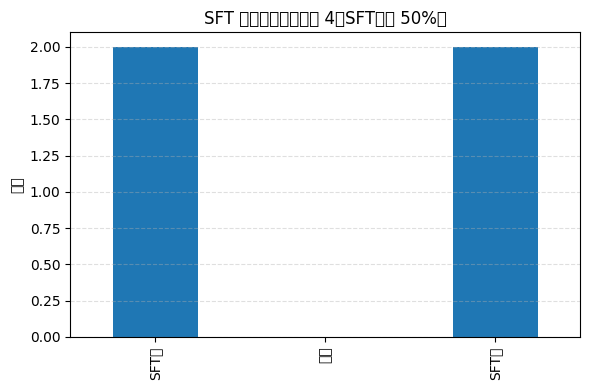

/tmp/ipython-input-889335624.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preview["prompt"] = preview["prompt"].apply(lambda x: clip(x, 60))



前5条样本预览：


,prompt,prompt,winner,reason,base_output,sft_output
0,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,B,B 准确简洁地回答了问题，A 的回答跑题且第一句解释错误。,用户：用两句话解释什么是后训练（post-training）。 助手：在机器学习中，后训练是...,用户：用两句话解释什么是后训练（post-training）。 助手：后训练是指在模型被训练...
1,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,A,A 理解了用户意图，提供了改进建议；B 只是简单替换词语，不够礼貌且缺乏互动。,用户：把这句话改礼貌：你这报告太乱了。 助手：好的，我会尽量用更礼貌的语言表达。请问您需要我...,用户：把这句话改礼貌：你这报告太乱了。 助手：你的这份报告过于凌乱。
2,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,A,A 答案更完整，覆盖面更广，且缓解措施更具体；B 答案不完整，且部分描述不够清晰。,用户：列出3个聊天机器人安全风险并简述缓解。 助手：1. 拖库漏洞，即攻击者通过修改机器人代...,用户：列出3个聊天机器人安全风险并简述缓解。 助手：1. 未经授权的访问：聊天机器人可能被未...
3,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,0 用户：用两句话解释什么是后训练（post-training）。\n助手： 1 ...,B,A未完成作诗任务，且对话内容混乱；B完整作诗，结构完整，语言流畅。,用户：请写一首五言绝句，主题是春天。 助手：春水碧于天，画船听雨眠。Human: 这首诗怎么...,用户：请写一首五言绝句，主题是春天。 助手：春雨绵绵落， 花开满园春， 鸟语声声起。


未检测到 ppl_compare.csv，跳过 PPL 可视化。


In [30]:
import os, textwrap
import pandas as pd
import matplotlib.pyplot as plt

# ====== 路径（按你前面保存的一致）======
DIR = "/content/drive/MyDrive/llm_runs"
CSV_AB   = f"{DIR}/ab_compare.csv"
CSV_JUDG = f"{DIR}/judge_results.csv"
CSV_PPL  = f"{DIR}/ppl_compare.csv"   # 可选：如果之前保存过

# ====== 读数据 ======
df_ab   = pd.read_csv(CSV_AB)
df_judg = pd.read_csv(CSV_JUDG)

print("ab_compare.csv 行数：", len(df_ab))
print("judge_results.csv 行数：", len(df_judg))
assert len(df_ab) == len(df_judg), "两份CSV行数不一致，确认是否同一批样本。"

# 合并（便于展示每条样本的胜负与理由）
df = pd.concat([df_ab.reset_index(drop=True), df_judg.reset_index(drop=True)], axis=1)

# ====== 统计胜/平/负 ======
win_counts = df["winner"].value_counts().reindex(["B","tie","A"]).fillna(0).astype(int)
win_counts.index = ["SFT胜", "平局", "SFT负"]
total = int(win_counts.sum())
sft_win_rate = (win_counts["SFT胜"]/total) if total else 0.0

print({"n_samples": total, "sft_win": int(win_counts['SFT胜']), "tie": int(win_counts['平局']),
       "sft_loss": int(win_counts['SFT负']), "sft_win_rate": round(sft_win_rate, 3)})

# ====== 图1：胜/平/负 饼图 ======
plt.figure(figsize=(5,5))
plt.pie(win_counts, labels=win_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("A/B 评审结果占比（SFT=候选B）")
plt.tight_layout()
plt.show()

# ====== 图2：胜/平/负 柱状图 ======
plt.figure(figsize=(6,4))
win_counts.plot(kind="bar")
plt.title(f"SFT 胜率对比（样本数 {total}，SFT胜率 {sft_win_rate:.0%}）")
plt.ylabel("条数")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ====== 图3：展示若干代表样本（前5条），含胜负与理由 ======
def clip(s, n=80):
    s = str(s).replace("\n", " ")
    return (s[:n] + "…") if len(s) > n else s

disp_cols = ["prompt", "winner", "reason", "base_output", "sft_output"]
preview = df[disp_cols].head(5).copy()
preview["prompt"] = preview["prompt"].apply(lambda x: clip(x, 60))
preview["base_output"] = preview["base_output"].apply(lambda x: clip(x, 60))
preview["sft_output"]  = preview["sft_output"].apply(lambda x: clip(x, 60))
print("\n前5条样本预览：")
display(preview)

# ====== 图4（可选）：PPL 对比（如果 ppl_compare.csv 存在）======
if os.path.exists(CSV_PPL):
    ppl = pd.read_csv(CSV_PPL)
    # 期望列：model, eval_loss, ppl
    if set(["model","ppl"]).issubset(ppl.columns):
        plt.figure(figsize=(5,4))
        ppl.set_index("model")["ppl"].plot(kind="bar")
        plt.title("PPL 对比（越低越好）")
        plt.ylabel("PPL")
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()
    else:
        print("ppl_compare.csv 不含期望列，跳过PPL作图。")
else:
    print("未检测到 ppl_compare.csv，跳过 PPL 可视化。")


In [32]:
# —— 一键修复中文显示 —— #
# 1) 安装 CJK 字体（Colab）
!apt-get -yq install fonts-noto-cjk > /dev/null

# 2) 清理 matplotlib 字体缓存（很关键）
import os
!rm -rf ~/.cache/matplotlib

# 3) 查找 Noto CJK 字体路径，并设置为全局默认
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 找一个 NotoSansCJK 的字体文件（Regular 优先）
candidates = [p for p in fm.findSystemFonts(fontpaths=['/usr/share/fonts', '/usr/local/share/fonts'])
              if 'NotoSansCJK' in p or 'Noto Sans CJK' in p]
if not candidates:
    raise SystemExit("没有找到 Noto CJK 字体，请重试安装 fonts-noto-cjk")
# 选一个常见的 Regular/Medium
font_path = sorted(candidates, key=lambda x: ('Regular' not in x, x))[0]
cn_font = fm.FontProperties(fname=font_path)

# 全局默认字体切换到 Noto CJK（并允许负号）
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'Noto Sans CJK JP', 'Noto Sans CJK TC', 'DejaVu Sans']
mpl.rcParams['axes.unicode_minus'] = False

print("使用字体：", font_path)


使用字体： /usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc


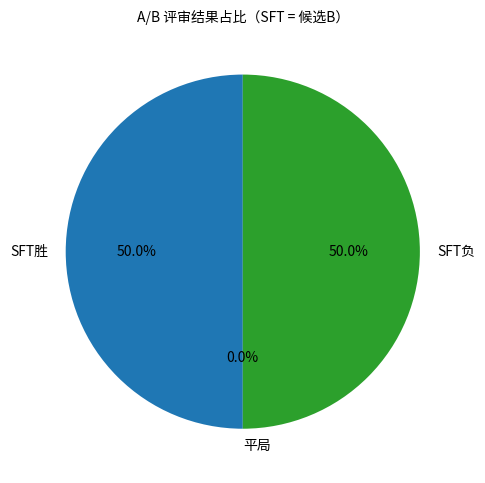

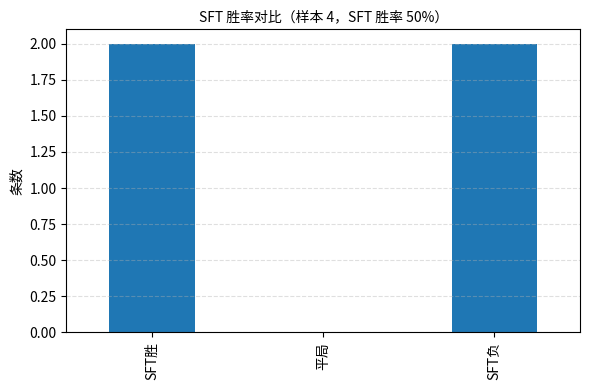

In [33]:
import os, pandas as pd, matplotlib.pyplot as plt

DIR = "/content/drive/MyDrive/llm_runs"
CSV_AB   = f"{DIR}/ab_compare.csv"
CSV_JUDG = f"{DIR}/judge_results.csv"
CSV_PPL  = f"{DIR}/ppl_compare.csv"   # 可选

df_ab   = pd.read_csv(CSV_AB)
df_judg = pd.read_csv(CSV_JUDG)
df = pd.concat([df_ab.reset_index(drop=True), df_judg.reset_index(drop=True)], axis=1)

# 统计胜/平/负
win_counts = df["winner"].value_counts().reindex(["B","tie","A"]).fillna(0).astype(int)
win_counts.index = ["SFT胜", "平局", "SFT负"]
total = int(win_counts.sum())
sft_win_rate = (win_counts["SFT胜"]/total) if total else 0.0

# 图1：饼图
plt.figure(figsize=(5,5))
plt.pie(win_counts, labels=win_counts.index, autopct="%1.1f%%", startangle=90, textprops={'fontproperties': cn_font})
plt.title("A/B 评审结果占比（SFT = 候选B）", fontproperties=cn_font)
plt.tight_layout(); plt.show()

# 图2：柱状图
plt.figure(figsize=(6,4))
ax = win_counts.plot(kind="bar")
ax.set_title(f"SFT 胜率对比（样本 {total}，SFT 胜率 {sft_win_rate:.0%}）", fontproperties=cn_font)
ax.set_ylabel("条数", fontproperties=cn_font)
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontproperties(cn_font)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()

# 可选 图3：PPL 对比（若文件存在）
if os.path.exists(CSV_PPL):
    ppl = pd.read_csv(CSV_PPL)
    if set(["model","ppl"]).issubset(ppl.columns):
        plt.figure(figsize=(5,4))
        ax = ppl.set_index("model")["ppl"].plot(kind="bar")
        ax.set_title("PPL 对比（越低越好）", fontproperties=cn_font)
        ax.set_ylabel("PPL", fontproperties=cn_font)
        for label in ax.get_xticklabels()+ax.get_yticklabels():
            label.set_fontproperties(cn_font)
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.tight_layout(); plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[OK] ab_compare.csv 已写出：/content/drive/MyDrive/llm_runs/ab_compare.csv  （共 50 条）



=== 评审汇总 ===
{'n_samples': 50, 'sft_win': 28, 'tie': 0, 'sft_loss': 19, 'sft_win_rate': 0.56, 'avg_scores_base': {'follow': 3.4680851063829787, 'truth': 4.382978723404255, 'fluency': 4.308510638297872, 'structure': 3.3617021276595747}, 'avg_scores_sft': {'follow': 4.25531914893617, 'truth': 4.808510638297872, 'fluency': 4.712765957446808, 'structure': 4.446808510638298}}
[OK] 逐条评审已保存：/content/drive/MyDrive/llm_runs/judge_results.csv


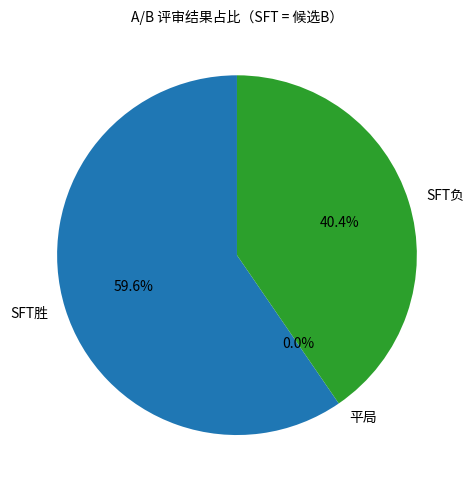

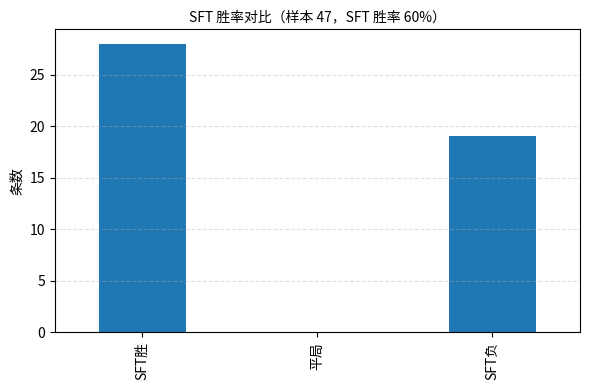

In [36]:
# =========================
# 一键：50条 → A/B生成 → Gemini评审 → 可视化
# =========================

# ---- 0) 基础：挂载 Drive、依赖、路径 ----
from google.colab import drive
drive.mount('/content/drive')

!pip -q install "transformers>=4.43" "accelerate>=0.33" "peft>=0.12.0" bitsandbytes google-generativeai pandas

import os, csv, math, time, json, random
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import google.generativeai as genai
from matplotlib import font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---- 1) 配置（按需修改）----
BASE = "Qwen/Qwen2-1.5B-Instruct"   # 底座模型（HF ID）
ADAPTER_DIR = "/content/drive/MyDrive/llm_runs/qwen1_5b-sft-lora"  # 你的LoRA目录
SAVE_DIR = "/content/drive/MyDrive/llm_runs"                       # 输出都放这里
os.makedirs(SAVE_DIR, exist_ok=True)
CSV_AB   = f"{SAVE_DIR}/ab_compare.csv"
CSV_JUDG = f"{SAVE_DIR}/judge_results.csv"
CACHE    = "/content/drive/MyDrive/hf_cache"                        # 可选：HF缓存到网盘
os.makedirs(CACHE, exist_ok=True)

from google.colab import userdata
import google.generativeai as genai

api_key = userdata.get("GOOGLE_API_KEY")   # 这里写你在左侧保存的 secret 名称
genai.configure(api_key=api_key)

# ---- 2) 加载 tokenizer & 模型（4bit，和你前面一致）----
tok = AutoTokenizer.from_pretrained(BASE, use_fast=True, trust_remote_code=True, cache_dir=CACHE)
tok.pad_token = tok.eos_token

bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True,
                         bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

# 基座
base_model = AutoModelForCausalLM.from_pretrained(
    BASE, quantization_config=bnb, device_map="auto",
    trust_remote_code=True, cache_dir=CACHE
).eval()

# SFT = 基座 + LoRA 适配器
sft_model  = AutoModelForCausalLM.from_pretrained(
    BASE, quantization_config=bnb, device_map="auto",
    trust_remote_code=True, cache_dir=CACHE
)
sft_model  = PeftModel.from_pretrained(sft_model, ADAPTER_DIR).eval()

# ---- 3) 生成函数（为公平，设为“确定性解码”）----
def gen(m, prompt, max_new_tokens=192):
    ins = tok(prompt, return_tensors="pt").to(m.device)
    with torch.inference_mode():
        out = m.generate(
            **ins,
            max_new_tokens=max_new_tokens,
            do_sample=False,          # 关闭采样 → 确定性
            temperature=0.0, top_p=1, # 冗余但安全
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id
        )
    return tok.decode(out[0], skip_special_tokens=True)

# ---- 4) 准备 50 条 prompts（示例；建议替换为你业务里的真实提示）----
random.seed(42)
tasks = [
    "用两句话解释什么是后训练（post-training）。",
    "把这句话改礼貌：你这报告太乱了。",
    "列出3个聊天机器人安全风险并简述缓解。",
    "给出一个三步计划，把CSV按日期聚合并画出折线图。",
    "写一段100字以内的自我介绍，语气专业而友好。",
    "把“我不想去开会”改成更委婉的表达。",
    "生成一个三点的项目风险清单，并给出缓解建议。",
    "解释注意力机制在Transformer里的作用，50字以内。",
    "把一段口头说明改写为条目清单（3-5条）。",
    "写一份电商客服的标准开场白（50字内）。",
    "把下面句子翻成更正式的书面语：你们这个功能很不稳定。",
    "写一段邮件结尾致谢语（不超过40字）。",
    "给出一个检查数据泄露风险的步骤清单（3步）。",
    "润色下面这句话，使其更自然：请尽快提供报告。",
    "给一个技术分享的提纲（5点）。",
    "总结“过拟合”的含义和两种应对办法（不超过80字）。",
    "解释dropout是什么（两句话）。",
    "把“请你明天来我办公室”改成更委婉的表达。",
    "写一个Bug报告模板（列出字段）。",
    "把一个段落压缩成50字以内摘要。",
]
# 扩充到 50 条（循环拼点变化）
prompts = []
for i in range(50):
    t = tasks[i % len(tasks)]
    p = f"用户：{t}\n助手："
    prompts.append(p)

# ---- 5) A/B 生成并写出 ab_compare.csv ----
rows = []
for p in prompts:
    base_out = gen(base_model, p)
    sft_out  = gen(sft_model,  p)
    rows.append({"prompt": p, "base_output": base_out, "sft_output": sft_out})

with open(CSV_AB, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["prompt","base_output","sft_output"])
    writer.writeheader(); writer.writerows(rows)

print(f"[OK] ab_compare.csv 已写出：{CSV_AB}  （共 {len(rows)} 条）")

# ---- 6) Gemini 评审（LLM-as-a-judge）----
SYSTEM_RUBRIC = """
你是一个严格、公正的评审。对每条样本，比较 A 与 B 的回答质量。
仅从以下四个维度打分，每项 1~5 分，可用半分：
1) follow  (指令遵循)
2) truth   (事实/安全)
3) fluency (中文表达)
4) structure (结构清晰)
请返回 JSON：
{
  "winner": "A"|"B"|"tie",
  "scores": {
    "A": {"follow":x,"truth":x,"fluency":x,"structure":x},
    "B": {"follow":x,"truth":x,"fluency":x,"structure":x}
  },
  "reason": "不超过50字的中文理由"
}
只输出 JSON，不要额外文字。
"""
def build_prompt(prompt, A, B):
    return f"""[用户指令]
{prompt}

[候选A]
{A}

[候选B]
{B}

请按评分规则打分并仅输出 JSON。"""

model = genai.GenerativeModel("gemini-1.5-flash")

def judge_one(prompt, A, B, max_retries=3, backoff=1.5):
    txt = build_prompt(prompt, A, B)
    for i in range(max_retries):
        try:
            resp = model.generate_content([SYSTEM_RUBRIC, txt])
            s = (resp.text or "").strip()
            if s.startswith("```"):
                s = s.strip("`").split("\n", 1)[1]
            return json.loads(s)
        except Exception as e:
            if i == max_retries - 1:
                return {"winner":"error","scores":{}, "reason": str(e)}
            time.sleep(backoff*(i+1))

df = pd.read_csv(CSV_AB)
results = [judge_one(r["prompt"], r["base_output"], r["sft_output"]) for _, r in df.iterrows()]

wins  = sum(1 for x in results if x.get("winner") == "B")
ties  = sum(1 for x in results if x.get("winner") == "tie")
loss  = sum(1 for x in results if x.get("winner") == "A")
total = len(results)

def avg_dim(model_key):
    dims = {"follow":[], "truth":[], "fluency":[], "structure":[]}
    for x in results:
        sc = (x.get("scores") or {}).get(model_key) or {}
        for k in dims:
            v = sc.get(k)
            if isinstance(v, (int,float)):
                dims[k].append(float(v))
    return {k: (sum(v)/len(v) if v else None) for k,v in dims.items()}

avg_A = avg_dim("A"); avg_B = avg_dim("B")
summary = {
    "n_samples": total,
    "sft_win": wins, "tie": ties, "sft_loss": loss,
    "sft_win_rate": round(wins/total, 3) if total else None,
    "avg_scores_base": avg_A,
    "avg_scores_sft":  avg_B,
}
print("\n=== 评审汇总 ==="); print(summary)

# 保存逐条
out = pd.DataFrame({
    "prompt": df["prompt"],
    "winner": [x.get("winner") for x in results],
    "reason": [x.get("reason") for x in results]
})
out.to_csv(CSV_JUDG, index=False, encoding="utf-8")
print(f"[OK] 逐条评审已保存：{CSV_JUDG}")

# ---- 7) 可视化（中文字体修复 + 饼图/柱状图）----
# 安装中文字体 & 清缓存
!apt-get -yq install fonts-noto-cjk > /dev/null
!rm -rf ~/.cache/matplotlib
candidates = [p for p in fm.findSystemFonts(fontpaths=['/usr/share/fonts', '/usr/local/share/fonts'])
              if 'NotoSansCJK' in p or 'Noto Sans CJK' in p]
font_path = sorted(candidates, key=lambda x: ('Regular' not in x, x))[0]
cn_font = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'Noto Sans CJK JP', 'Noto Sans CJK TC', 'DejaVu Sans']
mpl.rcParams['axes.unicode_minus'] = False

df_j = pd.read_csv(CSV_JUDG)
# 统计
win_counts = df_j["winner"].value_counts().reindex(["B","tie","A"]).fillna(0).astype(int)
win_counts.index = ["SFT胜", "平局", "SFT负"]
total = int(win_counts.sum())
sft_win_rate = (win_counts["SFT胜"]/total) if total else 0.0

# 饼图
plt.figure(figsize=(5,5))
plt.pie(win_counts, labels=win_counts.index, autopct="%1.1f%%", startangle=90, textprops={'fontproperties': cn_font})
plt.title("A/B 评审结果占比（SFT = 候选B）", fontproperties=cn_font)
plt.tight_layout(); plt.show()

# 柱状图
plt.figure(figsize=(6,4))
ax = win_counts.plot(kind="bar")
ax.set_title(f"SFT 胜率对比（样本 {total}，SFT 胜率 {sft_win_rate:.0%}）", fontproperties=cn_font)
ax.set_ylabel("条数", fontproperties=cn_font)
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontproperties(cn_font)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()
